In [1]:
import pyaudio
import struct
import numpy as np
import matplotlib.pyplot as plt
import wave
from sys import byteorder
from array import array
from struct import pack

#%matplotlib tk

### List input and output devices

In [2]:
#main pyaudio object
p = pyaudio.PyAudio()

#Get an overview of available input devices
info = p.get_host_api_info_by_index(0)
numdevices = info.get('deviceCount')
print("Available input devices (Microphones):")
for i in range(0, numdevices):
        if (p.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
            print("Input Device id ", i, " - ", p.get_device_info_by_host_api_device_index(0, i).get('name'))

Available input devices (Microphones):
Input Device id  0  -  Microsoft Sound Mapper - Input
Input Device id  1  -  Line (USB 2861 Device)
Input Device id  2  -  Microphone (Webcam 200)
Input Device id  3  -  Echo Cancelling Speakerphone (J
Input Device id  4  -  Microphone (High Definition Aud


In [3]:
#Get an overview of available output devices
info = p.get_host_api_info_by_index(0)
numdevices = info.get('deviceCount')
print("Available output devices (Speakers):")
for i in range(0, numdevices):
        if (p.get_device_info_by_host_api_device_index(0, i).get('maxOutputChannels')) > 0:
            print("Output Device id ", i, " - ", p.get_device_info_by_host_api_device_index(0, i).get('name'))

Available output devices (Speakers):
Output Device id  5  -  Microsoft Sound Mapper - Output
Output Device id  6  -  Speakers (High Definition Audio
Output Device id  7  -  SE790C (NVIDIA High Definition 
Output Device id  8  -  Digital Audio (S/PDIF) (High De
Output Device id  9  -  Echo Cancelling Speakerphone (J
Output Device id  10  -  SE790C (NVIDIA High Definition 


# Continuously record audio

In [13]:
#Set audio setting (Deepspeech can only handle signed 16-bit PCM)
THRESHOLD = 500
CHUNK_SIZE = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
INPUT_DEVICE = 3
OUTPUT_DEVICE = 8

def is_silent(snd_data):
    "Returns 'True' if below the 'silent' threshold"
    #print("Silence...")
    return max(snd_data) < THRESHOLD

def normalize(snd_data):
    "Average the volume out"
    MAXIMUM = 16384
    times = float(MAXIMUM)/max(abs(i) for i in snd_data)

    r = array('h')
    for i in snd_data:
        r.append(int(i*times))
    return r

def trim(snd_data):
    "Trim the blank spots at the start and end"
    def _trim(snd_data):
        snd_started = False
        r = array('h')

        for i in snd_data:
            if not snd_started and abs(i)>THRESHOLD:
                snd_started = True
                r.append(i)

            elif snd_started:
                r.append(i)
        return r

    # Trim to the left
    snd_data = _trim(snd_data)

    # Trim to the right
    snd_data.reverse()
    snd_data = _trim(snd_data)
    snd_data.reverse()
    return snd_data

def add_silence(snd_data, seconds):
    "Add silence to the start and end of 'snd_data' of length 'seconds' (float)"
    r = array('h', [0 for i in range(int(seconds*RATE))])
    r.extend(snd_data)
    r.extend([0 for i in range(int(seconds*RATE))])
    return r

def record():
    """
    Record a word or words from the microphone and 
    return the data as an array of signed shorts.

    Normalizes the audio, trims silence from the 
    start and end, and pads with 0.5 seconds of 
    blank sound to make sure VLC et al can play 
    it without getting chopped off.
    """
    p = pyaudio.PyAudio()
    
    #Audio capture criteria
    stream = p.open(
        format=FORMAT,
        channels=CHANNELS,
        rate=RATE,
        input=True,
        output=True,
        frames_per_buffer=CHUNK_SIZE,
        input_device_index = INPUT_DEVICE
    )
   
    #Amount time (loops before recording stops, dependent on speed of the system)
    silence_threshold = 120

    num_silent = 0
    snd_started = False

    r = array('h')

    while 1:
        # little endian, signed short
        snd_data = array('h', stream.read(CHUNK_SIZE))
        if byteorder == 'big':
            snd_data.byteswap()
        r.extend(snd_data)

        silent = is_silent(snd_data)

        if silent and snd_started:
            num_silent += 1
        elif not silent and not snd_started:
            snd_started = True

        if snd_started and num_silent > silence_threshold:
            break

    sample_width = p.get_sample_size(FORMAT)
    stream.stop_stream()
    stream.close()
    p.terminate()

    r = normalize(r)
    r = trim(r)
    r = add_silence(r, 0.5)
    return sample_width, r

def record_to_file(path):
    "Records from the microphone and outputs the resulting data to 'path'"
    sample_width, data = record()
    data = pack('<' + ('h'*len(data)), *data)

    wf = wave.open(path, 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(sample_width)
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()

#indefinite loop of sound recording
def start_recording():
    count = 0
    while __name__ == '__main__':
        count = count + 1
        print("please speak a word into the microphone")
        record_to_file('demo_%s.wav' %count)
        print("done - result written to demo_%s.wav" %count)
        #if 'demo_%s.wav' == activation_word:
            #actions
        #else:
            #delete 'demo_%s.wav'
            #count = 0

#run function
start_recording()

please speak a word into the microphone
done - result written to demo_1.wav
please speak a word into the microphone


KeyboardInterrupt: 

# Get wave pattern

In [7]:
#Set audio setting (Deepspeech can only handle signed 16-bit PCM)
THRESHOLD = 500
CHUNK_SIZE = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
INPUT_DEVICE = 3
OUTPUT_DEVICE = 8

In [8]:
#Get audio
stream = p.open(
    format=FORMAT,
    channels=CHANNELS,
    rate=RATE,
    input=True,
    output=True,
    frames_per_buffer=CHUNK_SIZE,
    input_device_index = INPUT_DEVICE
)

In [9]:
data = stream.read(CHUNK)

#Length data is the double of CHUNCK
print("data length is %s" %len(data))
#Convert bits to integers
data_int = np.array(struct.unpack(str(2 * CHUNK_SIZE) + 'B', data), dtype='b')[::2] + 127
print(data_int)

data length is 2048
[-89 -84 -87 ... 110  90  74]


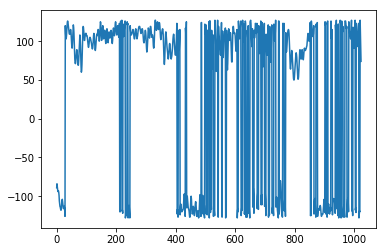

In [10]:
fig, ax = plt.subplots()
ax.plot(data_int, '-')
plt.show()